# Simulating Gene Expression Dynamics with SERGIO

SERGIO uses stochastic differential equations to simulate gene expression dynamics. The version of SERGIO demonstrated here is a modified version that allows for interventional experiments and more straightforward specification of the underlying directed acyclic graph (DAG). The modified version is originally forked from the BaCaDI (Hagele et al. (2023)) repository.

In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("notebook")
sns.set_theme(style="whitegrid", palette="tab10", font="Arial")
plt.rcParams['figure.figsize'] = [3, 3]

## Observational Setting

In [1]:
from sergio.interv_sergio import Sergio

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


A complete description of the settings used here can be found in the original paper. We randomly generate parameter settings and a directed acyclic graph (DAG) using the custom `generate_random_dag` function and give it back to the simulator via `custom_graph`.

In [35]:
np.random.seed(0)
# initialise Sergio object
simulator = Sergio(number_genes = 3, 
                 number_bins = 1, 
                 number_sc = 1000, 
                 noise_params = 1,
                 noise_type = "dpd")

# generate DAG and model parameters for SERGIO
adj_mat, k_params, b_params, hill_coeffs = simulator.generate_random_dag(max_parents=None, 
                                                                        min_k_param=1.0, max_k_param=5.0, 
                                                                        min_b_param=1.0, max_b_param=3.0, 
                                                                        min_hill_coeff=2.0, max_hill_coeff=2.0,
                                                                        generate_params=True, graph=None, dag_type='erdos', expected_degree=1)
# pass adjacency matrix and parameters to Sergio object
simulator.custom_graph(g=adj_mat.toarray(),
                        k=k_params.toarray(),
                        b=b_params.toarray(),
                        hill=hill_coeffs.toarray())

# generate observational data
simulator.simulate()
X = pd.DataFrame(simulator.getExpressions()[0].T).to_numpy()

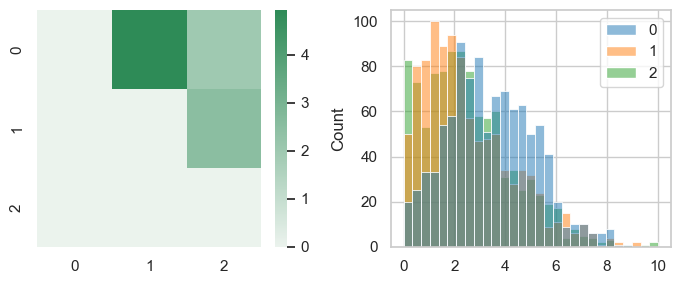

In [45]:
plt.rcParams['figure.figsize'] = [7, 3]
fig, ax = plt.subplots(1, 2)

# strength of relationships 
sns.heatmap(k_params.toarray(), cmap=sns.light_palette("seagreen", as_cmap=True), ax=ax[0])
sns.histplot(X, ax=ax[1])

plt.tight_layout()

## Interventional Setting

Here, we can reuse the DAG and parameter settings generated for the observational setting to generate interventional data. We intervene on $I=\{X_0\}$ by setting $X_0=0$ determinisitically and do not intervene on the remaining variables. 

In [47]:
np.random.seed(0)
# initialise Sergio object
simulator_int = Sergio(number_genes = 3, 
                 number_bins = 1, 
                 number_sc = 1000, 
                 noise_params = 1,
                 noise_type = "dpd",
                 kout=[True, False, False])

# pass adjacency matrix and parameters to Sergio object
simulator_int.custom_graph(g=adj_mat.toarray(),
                        k=k_params.toarray(),
                        b=b_params.toarray(),
                        hill=hill_coeffs.toarray())

# generate observational data
simulator_int.simulate()
X_int = pd.DataFrame(simulator_int.getExpressions()[0].T).to_numpy()

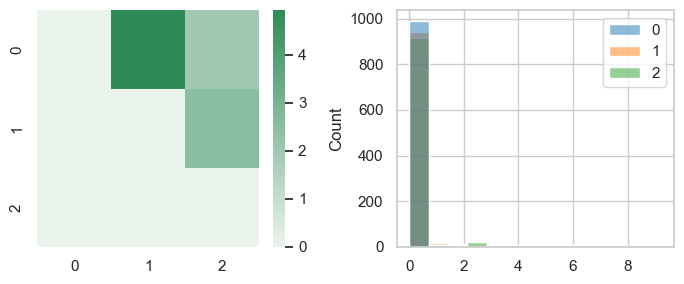

In [48]:
plt.rcParams['figure.figsize'] = [7, 3]
fig, ax = plt.subplots(1, 2)

# strength of relationships 
sns.heatmap(k_params.toarray(), cmap=sns.light_palette("seagreen", as_cmap=True), ax=ax[0])
sns.histplot(X_int, ax=ax[1])

plt.tight_layout()

In [49]:
# average treatment effects
print(X_int.mean(axis=0) - X.mean(axis=0))

[-3.32455335 -2.37809966 -2.2982675 ]
